# 1- Loading the data

In [5]:
# import libraries
import os
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow_io as tfio

import IPython.display as ipd
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [2]:
# read csv file 
df = pd.read_excel("D:\Ahmed\RDI\Gender\BVC_Gender.xlsx")
df.head()

,New_ID,Gender
0,4001,'Male'
1,4002,'Male'
2,4003,'Female'
3,4004,'Male'
4,4005,'Female'


In [3]:
# define the label 
label = df['Gender'][df['New_ID'] == 4001].iloc[0]
label

"'Male'"

In [4]:
# donwnload the date then extract
data_dir = pathlib.Path('./data')

if not data_dir.exists():
    tf.keras.utils.get_file(
        'waves.zip',
        origin=data_dir,
        extract=True,
        cache_dir='./',
        cache_subdir='data',
    )

# check classes in data_dir
os.listdir(data_dir)

['test', 'train', 'waves', 'waves.zip']

In [5]:
# build function to load audio data
def load_audio(file_path):
    audio_binary = tf.io.read_file(filename=file_path)
    waveform, sample_rate = tf.audio.decode_wav(audio_binary, desired_channels=1)
    waveform = tf.squeeze(waveform, axis= -1)
    # sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # waveform = tfio.audio.resample(waveform, rate_in=sample_rate, rate_out=16000)

    return waveform, sample_rate  

tf.Tensor(48000, shape=(), dtype=int32)


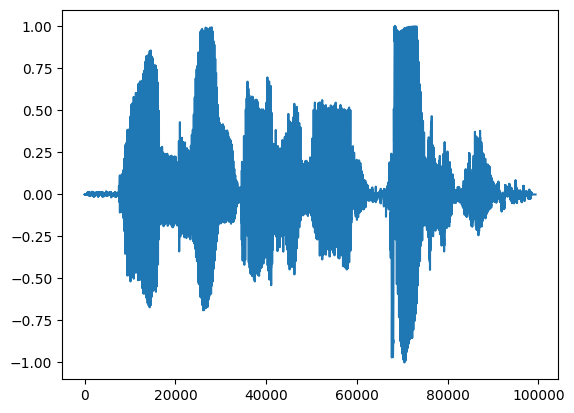

In [6]:
# plot the waveform and display audio
def plot_audio(file_path):
    waveform, sample_rate = load_audio(file_path)
    print(sample_rate)
    plt.plot(waveform.numpy())
    return waveform, sample_rate   
 
# random sample file to test
sample_file = 'data\waves\multiple_sentences\S_02_4513_VE1.wav' 
waveform, sample_rate = plot_audio(sample_file)
ipd.Audio(waveform.numpy(), rate=sample_rate)

In [7]:
import os
import wave
import pandas
import sys

def compare_header_and_size(wav_filename):
    with wave.open(wav_filename, 'rb') as fin:
        header_fsize = (fin.getnframes() * fin.getnchannels() * fin.getsampwidth()) + 44
    file_fsize = os.path.getsize(wav_filename)
    return header_fsize != file_fsize

# df = pandas.read_csv(sys.argv[1])
# invalid = df.apply(lambda x: compare_header_and_size(x['wav_filename']), axis=1)
# print('The following files are corrupted:')
# print(df[invalid].values)


In [8]:
print(compare_header_and_size('data\waves\multiple_sentences\S_01_4005_VV5.wav'))

False


In [9]:
# build function to load all audio files and return dataset
def load_audio_file(path:str, df):
    dataset = []
    walker = sorted([str(p) for p in pathlib.Path(path).glob(f'*.wav')])
    
    for i , filepath in enumerate(walker):
        path, filename = os.path.split(filepath)
        speaker, _ = os.path.splitext(filename)
        _ , __, ID, ___ = speaker.split('_')
        ID = int(ID)
    
        # define label 
        label = df['Gender'][df['New_ID'] == ID].iloc[0]
        
        # check files 
        try:
            if not compare_header_and_size(filepath): 
                # load audio
                waveform, sample_rate = load_audio(file_path= filepath)
                dataset.append([waveform, sample_rate, label])
                #print(len(dataset))
        except:
            print(filepath)
            os.remove(filepath)
    
    return dataset

In [10]:
# calling the load_audio_files function
train_dataset = load_audio_file(path="data\waves\multiple_sentences", df= df)

# check the dataset 
print('Len samples = ',len(train_dataset))
print('waveform = ',train_dataset[0][0])
print('sample_rate = ',train_dataset[0][1].numpy())
print('Labels = ', train_dataset[0][2])

Len samples =  3803
waveform =  tf.Tensor(
[ 3.05175781e-05  6.10351562e-05 -3.05175781e-04 ... -1.40686035e-02
 -1.44348145e-02 -1.39160156e-02], shape=(96479,), dtype=float32)
sample_rate =  48000
Labels =  'Male'


# 2- Spectrogram

In [11]:
# build function to create spectrogram
def get_spectrogram(waveform):
    
    # define FT param
    frame_length = 256
    frame_step = 128
    
    # add padding to make all waveforms equal
    zero_paddind = tf.zeros(abs(48000- tf.shape(waveform)), dtype=tf.float32)
    
    # concat audio with padding 
    waveform = tf.cast(waveform, tf.float32)
    waveform_eq = tf.concat([waveform, zero_paddind],0)
    
    # apply FT to get spectrogram
    Spect = tfio.audio.spectrogram(input=waveform_eq, nfft=frame_length, window=frame_length, stride=frame_step)
    
    # another option
    spectrogram = tf.signal.stft(waveform_eq ,frame_length=frame_length, frame_step=frame_step)
    spectrogram = tf.abs(spectrogram)
    
    return spectrogram, Spect

In [12]:
# Check get_Spectrogram func
spectrogram, Spect = get_spectrogram(train_dataset[0][0])
print('Shape of waveform', waveform.shape)
print('Shape of spectrogram', spectrogram.shape)
print('Shape of Spect', Spect.shape)

Shape of waveform (99371,)
Shape of spectrogram (1131, 129)
Shape of Spect (1133, 129)


C:\Users\DELL\AppData\Local\Temp\ipykernel_8344\3103903770.py:5: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


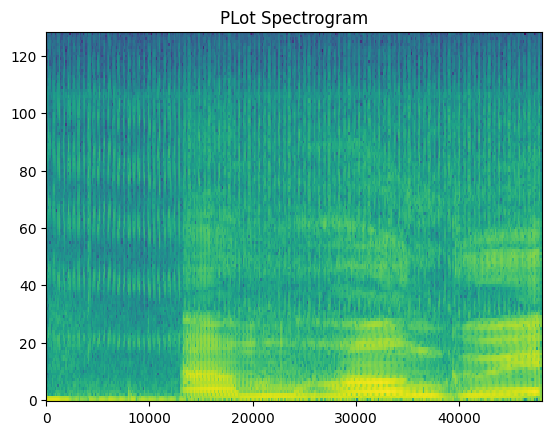

In [13]:
# build function to plot Spectrogram
def plot_spectrogram(spectrogram, ax, title):
    
    # convert fre to log scale
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    
    X = np.linspace(0,tf.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    
    ax.pcolormesh(X,Y,log_spec)
    ax.set_xlim([0,48000])
    ax.set_title(title)


fig, ax = plt.subplots()
plot_spectrogram(spectrogram, ax, 'PLot Spectrogram')
plt.show()

In [18]:
# make directory
test_dir_M = f'./data/test/Male/'
test_dir_F = f'./data/test/Female/'
train_dir_M = f'./data/train/Male/'
train_dir_F = f'./data/train/Female/'

os.makedirs(test_dir_M, exist_ok=True)
os.makedirs(test_dir_F, exist_ok=True)
os.makedirs(train_dir_M, exist_ok=True)
os.makedirs(train_dir_F, exist_ok=True)

In [19]:
# save the Spectrogram as Images
def create_images(dataset):
    
    for i , data in enumerate(dataset):
        waveform = dataset[i][0]
        spectrogram, spect = get_spectrogram(waveform)
        
        if i % 3 ==0:
            plt.imsave(f'data/test/{dataset[i][2][1:-1]}/spec_img{i}.png',spect.numpy(), cmap='gray')
        else:
            plt.imsave(f'data/train/{dataset[i][2][1:-1]}/spec_img{i}.png',spect.numpy(), cmap='gray')

In [20]:
# ok let`s create spectrogram images
create_images(dataset=train_dataset)

# Build the model


In [6]:
train_directory = './data/train/'
test_directory = './data/test/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(148, 148), seed=123,
    batch_size = 9, 
    validation_split=0.2, subset='validation')

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(148, 148),
    batch_size = 9, 
    validation_split=None, subset=None)

class_names = train_ds.class_names
print(class_names)

Found 1102 files belonging to 2 classes.
Using 220 files for validation.
Found 551 files belonging to 2 classes.
['Female', 'Male']


In [7]:
tf.keras.preprocessing.image_dataset_from_directory?

Signature:
tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Docstring:
Generates a `tf.data.Dataset` from image files in a directory.

If your directory structure is:

```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

Then calling `image_dataset_from_directory(main_directory,
labels='inferred')` will return a `tf.data.Dataset` that yields batches of
images from the subdirectories `class_a` and `class_b`, together with labels
0 and 1 (0 corresponding to `class_a` and 1 corresponding to `class_b`).

Supported image formats: jpeg, png, bmp, gif.
Animated gifs are truncated to the firs

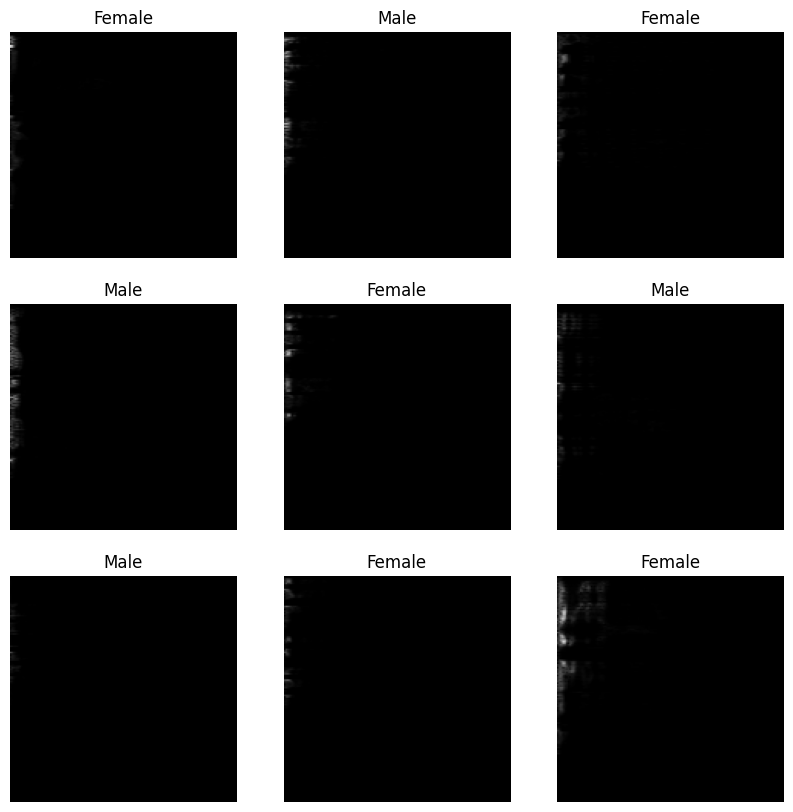

In [20]:
## Display spectrogram images

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
## Create the model

num_classes = 2
img_height = 148
img_width = 148

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [11]:
## Train the model

learning_rate = 0.125

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate)
metrics = ['accuracy']
model.compile(optimizer, loss_fn, metrics)

# Set the epocks
epochs = 25
print('\nFitting:')

# Train the model.
history = model.fit(train_ds, epochs=epochs)


Fitting:
Epoch 1/25
25/25 [==============================] - 1s 21ms/step - loss: 0.4538 - accuracy: 0.7864
Epoch 2/25
25/25 [==============================] - 1s 21ms/step - loss: 0.5209 - accuracy: 0.7182
Epoch 3/25
25/25 [==============================] - 1s 21ms/step - loss: 0.4474 - accuracy: 0.8045
Epoch 4/25
25/25 [==============================] - 1s 21ms/step - loss: 0.4153 - accuracy: 0.7818
Epoch 5/25
25/25 [==============================] - 1s 21ms/step - loss: 0.4316 - accuracy: 0.7818
Epoch 6/25
25/25 [==============================] - 1s 25ms/step - loss: 0.3064 - accuracy: 0.8682
Epoch 7/25
25/25 [==============================] - 1s 21ms/step - loss: 0.3778 - accuracy: 0.8545
Epoch 8/25
25/25 [==============================] - 1s 21ms/step - loss: 0.2881 - accuracy: 0.8864
Epoch 9/25
25/25 [==============================] - 1s 21ms/step - loss: 0.2545 - accuracy: 0.8773
Epoch 10/25
25/25 [==============================] - 1s 21ms/step - loss: 0.1846 - accuracy: 0.9000

In [19]:
correct = 0
batch_size = 0
for batch_num, (X, Y) in enumerate(test_ds):
    batch_size = len(Y)
    pred = model.predict(X)
    for i in range(batch_size):
        predicted = np.argmax(pred[i], axis=-1)
        actual = Y[i]
        #print(f'predicted {predicted}, actual {actual}')
        if predicted == actual:
            correct += 1
    break

print(f'Number correct: {correct} out of {batch_size}')
print(f'Accuracy {correct / batch_size}')


1/1 [==============================] - 0s 27ms/step
Number correct: 7 out of 9
Accuracy 0.7777777777777778
